In [1]:
#import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib

from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import datetime
from numpy import log
import pmdarima as pmd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import matplotlib

In [2]:
#get current working directory 
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/Users/julkakubisa/Documents/gold-price': ['main.ipynb', '.DS_Store', 'funs', '.ipynb_checkpoints', 'monthly_data.xlsx']


In [3]:
#import data
df = pd.read_excel("/Users/julkakubisa/Documents/gold-price/monthly_data.xlsx")

In [4]:
#set index to date
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df

,Value
Date,
1990-01-31,415.05
1990-02-28,407.70
1990-03-30,368.50
1990-04-30,367.75
1990-05-31,363.05
...,...
2022-02-28,1909.85
2022-03-31,1942.15
2022-04-29,1911.30


In [5]:
#fix the error 
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

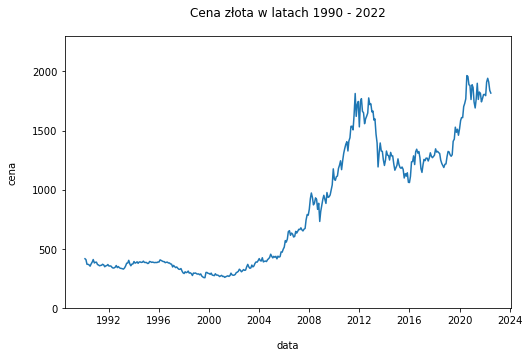

<Figure size 576x360 with 0 Axes>

In [6]:
#visualize price 
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0) 
plt.plot(df.Value)
plt.ylabel("cena", labelpad=15)
plt.xlabel("data", labelpad=15)
plt.title("Cena złota w latach 1990 - 2022", size=12, y=1.05)
plt.ylim([0, 2300])
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('cena złota 1990 - 2022.png', dpi=100)


In [7]:
#split data into out-of-sample and in-sample
train = df[:387]
test = df[387:390]


In [8]:
#print basic statistics
średnia = df.mean()
std = df.std()
lobs = df.count()
mediana = df.median()

print("liczba obserwacji:", lobs, "średnia:", średnia, "odchylenie:", std, "mediana:",
      mediana, "min:", df.min(), "max:", df.max(), df.skew())

print("kurtoza:", df.kurtosis())

liczba obserwacji: Value    390
dtype: int64 średnia: Value    822.815513
dtype: float64 odchylenie: Value    533.028148
dtype: float64 mediana: Value    590.625
dtype: float64 min: Value    254.8
dtype: float64 max: Value    1964.9
dtype: float64 Value    0.542974
dtype: float64
kurtoza: Value   -1.191295
dtype: float64


In [9]:
df.describe(include='all')

,Value
count,390.000000
mean,822.815513
std,533.028148
min,254.800000
25%,357.525000
50%,590.625000
75%,1281.775000
max,1964.900000


In [10]:
#differencing data
df_diff = train.diff()
df_diff.dropna(inplace=True)

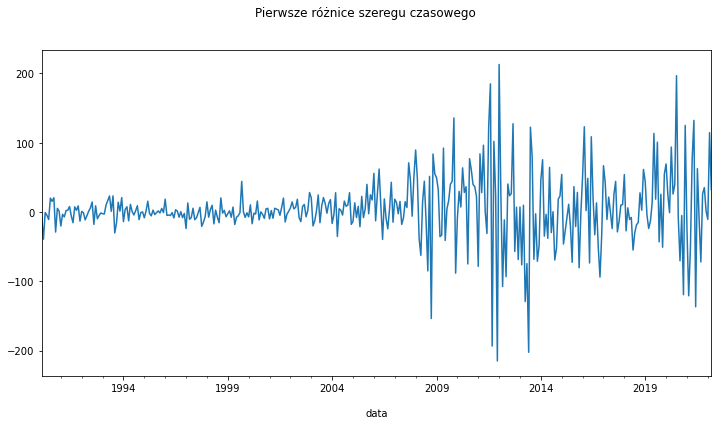

<Figure size 576x360 with 0 Axes>

In [11]:
#plot diff data
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('Pierwsze różnice szeregu czasowego')
df_diff['Value'].plot(ax=ax)
plt.xlabel("data", labelpad=15)
fig2 = plt.gcf()
plt.show()
plt.draw()
fig2.savefig('pierwsze różnice.png', dpi=100)


In [12]:
#stationarity 

#ADF test for non-differenced data
result = adfuller(df['Value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -0.181851
p-value: 0.940651
Critical Test Statistics Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


In [13]:
#ADF test for differenced data
result_diff = adfuller(df_diff['Value'])
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Test Statistics Values:')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))
    


ADF Statistic: -4.879020
p-value: 0.000038
Critical Test Statistics Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


In [14]:
#test KPSS

#KPSS for non-diff data 
def kpss_test(df, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(df.Value, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df)

KPSS Statistic: 1.9306462428251001
p-value: 0.01
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [15]:
#KPSS test for diff data 
def kpss_test_diff(df_diff, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(df_diff.Value, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test_diff(df_diff)

KPSS Statistic: 0.25074699671292267
p-value: 0.1
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


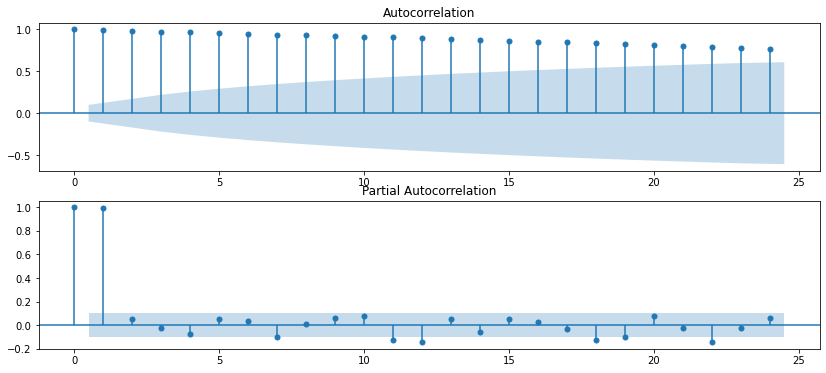

In [16]:
#ACF i PACF for non-diff data
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df['Value'], lags=24, ax=ax1)
ax2 = plot_pacf(df['Value'], lags=24, ax=ax2)
plt.show()


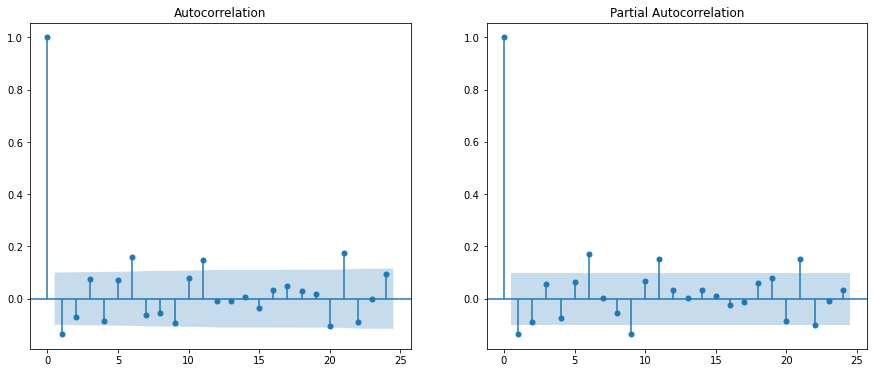

<Figure size 576x360 with 0 Axes>

In [17]:
#ACF i PACF dla diff data 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff['Value'], lags=24, ax=ax1)
ax2 = plot_pacf(df_diff['Value'], lags=24, ax=ax2)
fig3 = plt.gcf()
plt.show()
plt.draw()
fig3.savefig('ACF i PACF')



In [18]:
#white noise test 
train = df[:387]
test = df[387:]
df_diff = train.diff()
df_diff.dropna(inplace=True)


#Box-Pierce test 
acorr_ljungbox(df_diff['Value'], lags=[24], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
24,70.13457,0.000002,67.645164,0.000005


In [19]:
#Ljung Box test 
acorr_ljungbox(df_diff['Value'], lags=[24], return_df=True)



,lb_stat,lb_pvalue
24,70.13457,0.000002


In [20]:
#ARIMA best model (autoarima)
def arimamodel(df):
    autoarima_model = pmd.auto_arima(train,
                                     start_p=1,
                                     start_q=1,
                                     test="adf",
                                     m=12, 
                                     d=1,
                                     seasonal = False,
                                     error_action = 'ignore',
                                     suppress_warnings=True,
                                     trace=True)
    
arima_model = arimamodel(df['Value'])



/opt/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4077.946, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4082.877, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4077.788, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4076.584, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4083.525, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4077.335, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4078.742, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4078.302, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.035 seconds


In [21]:
# 1,1,1 ARIMA Model
model1 = ARIMA(train.Value, order=(1,1,1))
model_fit1 = model1.fit(disp=0)
print(model_fit1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  386
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2034.975
Method:                       css-mle   S.D. of innovations             47.133
Date:                Fri, 14 Oct 2022   AIC                           4077.949
Time:                        18:06:05   BIC                           4093.773
Sample:                    02-28-1990   HQIC                          4084.224
                         - 03-31-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9382      1.956      2.013      0.044       0.105       7.772
ar.L1.D.Value     0.1878      0.224      0.837      0.402      -0.252       0.627
ma.L1.D.Value    -0.3383      0.212     

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency BM wi

In [28]:
# 1,1,0 ARIMA Model
model2 = ARIMA(train.Value, order=(1,1,0))
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  386
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2035.894
Method:                       css-mle   S.D. of innovations             47.246
Date:                Fri, 14 Oct 2022   AIC                           4077.788
Time:                        14:36:00   BIC                           4089.656
Sample:                    02-28-1990   HQIC                          4082.495
                         - 03-31-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9509      2.120      1.864      0.062      -0.204       8.106
ar.L1.D.Value    -0.1348      0.050     -2.675      0.007      -0.234      -0.036
                                    Root

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency BM wi

In [29]:
# 0,1,1 ARIMA Model
model3 = ARIMA(train.Value, order=(0,1,1))
model_fit3 = model3.fit(disp=0)
print(model_fit3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  386
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2035.293
Method:                       css-mle   S.D. of innovations             47.172
Date:                Fri, 14 Oct 2022   AIC                           4076.586
Time:                        14:36:01   BIC                           4088.454
Sample:                    02-28-1990   HQIC                          4081.293
                         - 03-31-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9453      2.027      1.946      0.052      -0.029       7.919
ma.L1.D.Value    -0.1560      0.053     -2.954      0.003      -0.259      -0.052
                                    Root

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency BM wi

In [30]:
# 0,1,0 ARIMA Model
model4 = ARIMA(train.Value, order=(0,1,0))
model_fit4 = model4.fit(disp=0)
print(model_fit4.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  386
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2039.438
Method:                           css   S.D. of innovations             47.683
Date:                Fri, 14 Oct 2022   AIC                           4082.877
Time:                        14:36:07   BIC                           4090.788
Sample:                    02-28-1990   HQIC                          4086.014
                         - 03-31-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9562      2.427      1.630      0.103      -0.801       8.713


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency BM wi

In [35]:
df_wyciete = df[350:390]

result = pd.concat([fc_series, df_wyciete], axis=1, join='outer')
result.columns = ['Progoza','Wartości']

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


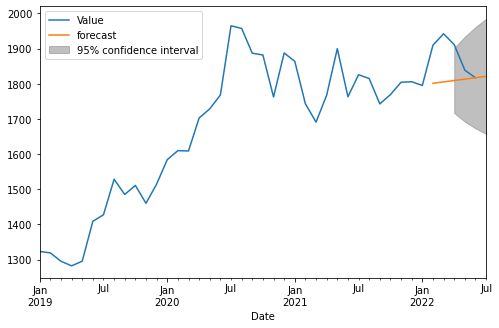

In [40]:
#plot the best model 
fig, ax = plt.subplots()
ax = df.loc['2019':].plot(ax=ax)
fig = model_fit3.plot_predict('2022-02', '2022-07', dynamic=True, ax=ax, plot_insample=False)
plt.show()

In [43]:
#are residuals white noise 
import statsmodels.api as sm

#ljung box test
sm.stats.acorr_ljungbox(model_fit3.resid, lags=[24], return_df=True)


,lb_stat,lb_pvalue
24,58.05904,0.000119


In [46]:
#estimated values 
y_pred = pd.Series(model_fit3.forecast(3)[0], index = df[387:].index)

#real values
y_true = df[387:]

y_pred

Date
2022-04-29    1939.034247
2022-05-31    1942.979529
2022-06-30    1946.924811
dtype: float64

In [48]:
#ex-post 
import sklearn.metrics as metrics

mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)  
r2 = metrics.r2_score(y_true, y_pred)

print("Results of sklearn.metrics:")
print("MAPE:",mape)
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R:", r2)


Results of sklearn.metrics:
MAPE: 0.04757650767259971
MAE: 87.31286251462355
MSE: 9507.955087190312
RMSE: 97.50874364481533
R: -4.847394912493179


In [50]:
#normalized rmse 
normalized = rmse/(df.max()-df.min())
normalized

Value    0.057019
dtype: float64